Imports

In [50]:
import os
import sys
import pickle
import math

import numpy as np
import pandas as pd

import scipy.stats as stats
from scipy.integrate import simpson
from scipy import interpolate, integrate, signal
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import seaborn as sns
import pyabf
import pingouin as pg

# =========================
# Custom scripts
# =========================
sys.path.append(r"E:\Dropbox (Weizmann Institute)\Lab\Code\Python Scripts Jupyter")
from entities_v2 import GCaMPData, LimbData, Frame, Clip, Experiment  # noqa: F401

CONFIGURATION & CONSTANTS

In [51]:
# Data folder (pkl files)
DATA_FOLDER = r'Z:\UriMons\Fiber Photometry\GCaMP\Habenula\Processed_Data\Pickles'

In [52]:
# Sampling and peak detection parameters
FS = 50                # Hz for GCaMP data
GROOMING_FPS = 30      # Frames per second for grooming annotations (not used below but kept)

PRETRIGGER_WINDOW = 0.1 * FS
POSTTRIGGER_WINDOW = 0.75 * FS

THRESH_MIN = 1
THRESH_MAX = 10
THRESH_PROMINENCE = 2
THRESH_MIN_WIDTH = 10 * (FS / 1000)

# Binning
BIN_SIZE = 15000  # 3000 = 1 min (at 50 Hz), 15000 = 5 min, 30000 = 10 min

# Plotting parameters (adjustable)
MARKER_SIZE = 8
LINE_WIDTH = 2
TITLE_FONTSIZE = 16
AXIS_LABEL_FONTSIZE = 14
LEGEND_FONTSIZE = 12
TICK_FONTSIZE = 12


Unified phase mapping

In [53]:
# Must match the window used in get_gcamp_data_Z_score(end_frame=150000)
TOTAL_FRAMES = 150_000          # analyze 0..149,999
N_BINS       = math.ceil(TOTAL_FRAMES / BIN_SIZE)
BIN_STARTS   = list(range(0, TOTAL_FRAMES, BIN_SIZE))

# --- Choose how to label bins ---
# 'custom'    -> use your own list of labels (must have N_BINS entries) --> good for 10 phases
# 'phase'     -> auto "P1", "P2", etc... --> good for 5 phases
# 'timerange' -> auto "start_s–end_s" (in seconds) --> good for time bins 
LABEL_MODE = 'timerange'  # 'custom' | 'phase' | 'timerange'

# If LABEL_MODE == 'custom', define exactly N_BINS labels here (left → right):
# With BIN_SIZE = 15000 and TOTAL_FRAMES = 150000 → N_BINS = 10
CUSTOM_LABELS = [
    "BL 1", "BL 2",
    "Stress 1", "Stress 2",
    "PS 1", "PS 2", "PS 3", "PS 4", "PS 5", "PS 6",
]

# --- Build PHASE_MAPPING keyed by bin start frame ---
PHASE_MAPPING = {}
for i, start in enumerate(BIN_STARTS):
    if LABEL_MODE == 'custom':
        if len(CUSTOM_LABELS) != N_BINS:
            raise ValueError(
                f"CUSTOM_LABELS must have {N_BINS} items (has {len(CUSTOM_LABELS)})."
            )
        label = CUSTOM_LABELS[i]
    elif LABEL_MODE == 'phase':
        label = f"P{i+1}"
    elif LABEL_MODE == 'timerange':
        start_s = start // FS
        end_s   = min(start + BIN_SIZE, TOTAL_FRAMES) // FS
        label   = f"{start_s}-{end_s}s"
    else:
        raise ValueError("LABEL_MODE must be 'custom', 'phase', or 'timerange'.")
    PHASE_MAPPING[start] = label

# --- (Optional) helper to fetch a label for an arbitrary bin_start) ---
def phase_label_from_start(start_frame: int) -> str:
    """Return matching phase label for a bin start (falls back to 'Phase <start>')."""
    return PHASE_MAPPING.get(start_frame, f"Phase {start_frame}")

# --- (Optional) quick sanity check ---
print(f"BIN_SIZE={BIN_SIZE} frames | TOTAL_FRAMES={TOTAL_FRAMES} | N_BINS={N_BINS}")
print("First 5 labels:", [PHASE_MAPPING[s] for s in BIN_STARTS[:5]])
# =========================================================


BIN_SIZE=15000 frames | TOTAL_FRAMES=150000 | N_BINS=10
First 5 labels: ['0-300s', '300-600s', '600-900s', '900-1200s', '1200-1500s']


DATA LOADING & GROUPING

In [54]:
def load_experiments(data_folder: str):
    loaded_objects = []
    if not os.path.isdir(data_folder):
        print(f"DATA_FOLDER does not exist or is not a directory: {data_folder}")
        return loaded_objects

    for file in os.listdir(data_folder):
        if file.endswith(".pkl"):
            file_path = os.path.join(data_folder, file)
            try:
                with open(file_path, 'rb') as f:
                    loaded_object = pickle.load(f)
                loaded_objects.append(loaded_object)
                print(f"Loaded: {file}")
            except Exception as e:
                print(f"Failed loading {file}: {e}")

    print(f"Total .pkl files loaded: {len(loaded_objects)}")
    return loaded_objects


def get_sapap_genotype(genotype_string):
    if isinstance(genotype_string, str) and "Sapap(" in genotype_string:
        start_index = genotype_string.find("Sapap(") + len("Sapap(")
        end_index = genotype_string.find(")", start_index)
        return genotype_string[start_index:end_index]
    return None


def separate_groups(loaded_objects):
    group_WT, group_KO = [], []
    for obj in loaded_objects:
        genotype = get_sapap_genotype(getattr(obj, "Genotype", None))
        if genotype == "WT":
            group_WT.append(obj)
        elif genotype == "KO":
            group_KO.append(obj)
        else:
            print(f"Warning: Unknown/missing Sapap genotype for mouse ID {getattr(obj, 'Mouse_id', '??')}")
    print(f"Number of WT mice: {len(group_WT)}")
    print(f"Number of KO mice: {len(group_KO)}")
    return group_WT, group_KO

GCaMP DATA PROCESSING & PLOTTING

In [55]:
def process_gcamp_data(group):
    """Returns dict: mouse_id -> z-score array."""
    filtered_data = {}
    for obj in group:
        mouse_id = getattr(obj, "Mouse_id", None)
        try:
            gcamp_z_score, time_seconds = obj.get_gcamp_data_Z_score(
                start_frame=0, end_frame=TOTAL_FRAMES
            )
            if gcamp_z_score is None or len(gcamp_z_score) == 0:
                print(f"Empty GCaMP data for mouse ID {mouse_id}. Skipping.")
                continue

            filtered_data[mouse_id] = np.asarray(gcamp_z_score)
            print(f"Processed GCaMP data for mouse ID {mouse_id}")

        except Exception as e:
            print(f"Error processing GCaMP data for mouse ID {mouse_id}: {e}")

    return filtered_data


def plot_gcamp_data(filtered_data_dict, group_name):
    num_mice = len(filtered_data_dict)
    if num_mice == 0:
        print(f"No data available for {group_name}. Skipping plot.")
        return

    ncols = 4
    nrows = (num_mice // ncols) + (1 if num_mice % ncols else 0)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows))
    axes = np.array(axes).flatten()

    for idx, (mouse_id, data_array) in enumerate(filtered_data_dict.items()):
        axes[idx].plot(data_array)
        axes[idx].set_title(f"{group_name} Mouse {mouse_id}")
        axes[idx].set_xlabel('Time Points')
        axes[idx].set_ylabel('Z-score')
        axes[idx].tick_params(labelsize=8)

    for ax in axes[num_mice:]:
        ax.axis('off')

    plt.suptitle(f'GCaMP Data for {group_name}')
    plt.tight_layout()
    plt.show()

PEAK DETECTION & EVENT TABLE CREATION

In [56]:
PEAK_TABLE_COLUMNS = [
    'mouse_id', 'event', 'peak_index', 'peak_time_s',
    'event_window_start', 'event_window_end',
    'peak_amp', 'width_ms', 'inst_freq', 'isi_s', 'AUC'
]


def process_group_peaks(filtered_data_dict, group_name):
    if not filtered_data_dict:
        print(f"No data for {group_name}. Returning empty peaks table.")
        return pd.DataFrame(columns=PEAK_TABLE_COLUMNS)

    group_table = pd.DataFrame(columns=PEAK_TABLE_COLUMNS)

    for mouse_id, filterdata in filtered_data_dict.items():
        peaks_signal = -filterdata  # invert signal for peak finding

        peaks, peaks_dict = find_peaks(
            -peaks_signal,
            height=(THRESH_MIN, THRESH_MAX),
            prominence=THRESH_PROMINENCE,
            width=THRESH_MIN_WIDTH,
            rel_height=0.5
        )

        if len(peaks) == 0:
            continue

        table = pd.DataFrame({
            'mouse_id': mouse_id,
            'event': np.arange(1, len(peaks) + 1),
            'peak_index': peaks,
            'peak_time_s': peaks / FS,
            'event_window_start': peaks_dict['left_ips'] - PRETRIGGER_WINDOW,
            'event_window_end': peaks_dict['right_ips'] + POSTTRIGGER_WINDOW,
            'peak_amp': peaks_dict['peak_heights'],
            'width_ms': peaks_dict['widths'] / (FS / 1000),
        })

        # frequency/ISI
        table['inst_freq'] = np.insert((1 / (np.diff(table['peak_index']) / FS)), 0, np.nan)
        table['isi_s'] = np.insert(np.diff(table['peak_index']) / FS, 0, np.nan)

        # AUC (kept as in your original logic)
        table['AUC'] = [
            abs(round(peaks_signal[int(row.event_window_start):int(row.event_window_end)].sum() / (FS / 1000), 2))
            for _, row in table.iterrows()
        ]

        group_table = pd.concat([group_table, table], ignore_index=True)

    if group_table.empty:
        print(f"No peaks detected for {group_name}. Returning empty table.")
        return pd.DataFrame(columns=PEAK_TABLE_COLUMNS)

    group_table = group_table.sort_values(by='peak_index').reset_index(drop=True)
    print(f"Combined results table for {group_name} mice:")
    print(group_table)
    return group_table


def plot_selected_events(group_table, filtered_data_dict, group_name, event_step):
    # Guardrails so empty groups don't crash plotting
    if group_table is None or group_table.empty:
        print(f"No events found for {group_name}. Skipping selected-event plots.")
        return
    if not filtered_data_dict:
        print(f"No signal data for {group_name}. Skipping selected-event plots.")
        return

    selected_events = group_table.iloc[::event_step]
    if selected_events.empty:
        print(f"No events to plot for {group_name} with event_step={event_step}. Skipping.")
        return

    num_plots = len(selected_events)
    cols = 4
    rows = int(np.ceil(num_plots / cols))
    if rows <= 0:
        print(f"No rows to plot for {group_name}. Skipping.")
        return

    fig, axes = plt.subplots(
        rows, cols,
        figsize=(cols * 4, rows * 3),
        gridspec_kw={'wspace': 0.4, 'hspace': 0.6}
    )
    axes = np.array(axes).flatten()

    plotted = 0
    for _, row in selected_events.iterrows():
        mouse_id = row['mouse_id']
        start_idx = int(row['event_window_start'])
        end_idx = int(row['event_window_end'])

        if mouse_id not in filtered_data_dict:
            print(f"Warning: Mouse ID {mouse_id} not found in {group_name} data. Skipping event.")
            continue

        signal_segment = filtered_data_dict[mouse_id][start_idx:end_idx]
        if len(signal_segment) == 0:
            continue

        ax = axes[plotted]
        ax.plot(np.arange(start_idx, end_idx) / FS, signal_segment)
        ax.set_title(f"{group_name} Event {row['event']} (Mouse {mouse_id})", fontsize=10)
        ax.set_xlabel("Time (s)", fontsize=8)
        ax.set_ylabel("Signal", fontsize=8)
        ax.tick_params(axis='both', labelsize=7)
        plotted += 1

        if plotted >= len(axes):
            break

    for j in range(plotted, len(axes)):
        fig.delaxes(axes[j])

    if plotted == 0:
        plt.close(fig)
        print(f"No valid events were plotted for {group_name}.")
        return

    plt.suptitle(f"Selected Events for {group_name} Mice", fontsize=12)
    plt.show()



BINNED STATISTICS CALCULATION

In [57]:
def compute_peak_stats_per_bin(filtered_data_dict, group_name):
    if not filtered_data_dict:
        print(f"No data for {group_name}. Skipping peak stats per bin.")
        return pd.DataFrame()

    peak_stats_bins = {
        "mouse_id": [],
        "bin_start": [],
        "bin_end": [],
        "peak_count": [],
        "avg_amplitude": [],
        "std_amplitude": [],
        "sem_amplitude": [],
        "median_amplitude": []
    }

    for mouse_id, filterdata in filtered_data_dict.items():
        peaks_signal = -filterdata
        peaks, peaks_dict = find_peaks(
            -peaks_signal,
            height=(THRESH_MIN, THRESH_MAX),
            prominence=THRESH_PROMINENCE,
            width=THRESH_MIN_WIDTH,
            rel_height=0.5
        )

        signal_length = len(peaks_signal)
        num_bins = (signal_length // BIN_SIZE) + (1 if signal_length % BIN_SIZE != 0 else 0)

        table = pd.DataFrame({
            'event': np.arange(1, len(peaks) + 1),
            'peak_index': peaks,
            'peak_time_s': peaks / FS,
            'event_window_start': peaks_dict.get('left_ips', np.array([])) - PRETRIGGER_WINDOW,
            'event_window_end': peaks_dict.get('right_ips', np.array([])) + POSTTRIGGER_WINDOW,
            'peak_amp': peaks_dict.get('peak_heights', np.array([])),
        })

        for i in range(num_bins):
            bin_start = i * BIN_SIZE
            bin_end = bin_start + BIN_SIZE
            peaks_in_bin = table[(table['peak_index'] >= bin_start) & (table['peak_index'] < bin_end)]

            peak_stats_bins["mouse_id"].append(mouse_id)
            peak_stats_bins["bin_start"].append(bin_start)
            peak_stats_bins["bin_end"].append(bin_end)
            peak_stats_bins["peak_count"].append(len(peaks_in_bin))

            if not peaks_in_bin.empty:
                mean_amp = np.mean(peaks_in_bin['peak_amp'])
                std_amp = np.std(peaks_in_bin['peak_amp'])
                sem_amp = std_amp / np.sqrt(len(peaks_in_bin))
                median_amp = np.median(peaks_in_bin['peak_amp'])
            else:
                mean_amp, std_amp, sem_amp, median_amp = np.nan, np.nan, np.nan, np.nan

            peak_stats_bins["avg_amplitude"].append(mean_amp)
            peak_stats_bins["std_amplitude"].append(std_amp)
            peak_stats_bins["sem_amplitude"].append(sem_amp)
            peak_stats_bins["median_amplitude"].append(median_amp)

    peak_stats_df = pd.DataFrame(peak_stats_bins)
    print(f"\nPeak statistics per bin for {group_name} mice:")
    print(peak_stats_df)
    return peak_stats_df


def compute_group_peak_stats(peak_stats_df, group_name):
    if peak_stats_df is None or peak_stats_df.empty:
        print(f"No peak stats for {group_name}. Skipping group peak stats.")
        return pd.DataFrame()

    num_mice_per_bin = peak_stats_df.groupby("bin_start")["mouse_id"].nunique()

    peak_count_stats = peak_stats_df.groupby("bin_start").agg(
        peak_count_mean=("peak_count", "mean"),
        peak_count_std=("peak_count", "std")
    ).reset_index()

    peak_count_stats["sem_peak_count"] = peak_count_stats["peak_count_std"] / np.sqrt(num_mice_per_bin.values)
    peak_count_median = peak_stats_df.groupby("bin_start")["peak_count"].median().reset_index(name="peak_count_median")

    group_peak_stats = pd.merge(peak_count_stats, peak_count_median, on="bin_start")

    amplitude_stats = peak_stats_df.groupby("bin_start").agg(
        avg_amplitude_mean=("avg_amplitude", "mean"),
        avg_amplitude_std=("avg_amplitude", "std")
    ).reset_index()

    amplitude_stats["sem_amplitude"] = amplitude_stats["avg_amplitude_std"] / np.sqrt(num_mice_per_bin.values)
    amplitude_stats["median_amplitude_median"] = peak_stats_df.groupby("bin_start")["median_amplitude"].median().values
    amplitude_stats["median_amplitude_std"] = peak_stats_df.groupby("bin_start")["median_amplitude"].std().values
    amplitude_stats["median_amplitude_sem"] = amplitude_stats["median_amplitude_std"] / np.sqrt(num_mice_per_bin.values)

    group_peak_stats = pd.merge(group_peak_stats, amplitude_stats, on="bin_start")
    group_peak_stats["bin_end"] = group_peak_stats["bin_start"] + BIN_SIZE

    print(f"\nOverall peak statistics per bin for {group_name} mice:")
    print(group_peak_stats)

    for _, row in group_peak_stats.iterrows():
        label = phase_label_from_start(int(row['bin_start']))
        print(
            f"{label} (Bin {row['bin_start']}-{row['bin_end']}): "
            f"Peak Count: Mean = {row['peak_count_mean']:.2f} (Median = {row['peak_count_median']:.2f}, SEM = {row['sem_peak_count']:.2f}) | "
            f"Amplitude: Mean = {row['avg_amplitude_mean']:.2f} (Median = {row['median_amplitude_median']:.2f})"
        )

    return group_peak_stats


def compute_auc_per_bin(filtered_data_dict, group_name):
    if not filtered_data_dict:
        print(f"No data for {group_name}. Skipping AUC stats per bin.")
        return pd.DataFrame()

    auc_bins = {
        "mouse_id": [],
        "bin_start": [],
        "bin_end": [],
        "total_AUC": [],
        "std_AUC": [],
        "sem_AUC": [],
        "median_AUC": []
    }

    for mouse_id, filterdata in filtered_data_dict.items():
        peaks_signal = -filterdata
        peaks, peaks_dict = find_peaks(
            -peaks_signal,
            height=(THRESH_MIN, THRESH_MAX),
            prominence=THRESH_PROMINENCE,
            width=THRESH_MIN_WIDTH,
            rel_height=0.5
        )

        signal_length = len(peaks_signal)
        num_bins = (signal_length // BIN_SIZE) + (1 if signal_length % BIN_SIZE != 0 else 0)

        table = pd.DataFrame({
            'event': np.arange(1, len(peaks) + 1),
            'peak_index': peaks,
            'peak_time_s': peaks / FS,
            'event_window_start': peaks_dict.get('left_ips', np.array([])) - PRETRIGGER_WINDOW,
            'event_window_end': peaks_dict.get('right_ips', np.array([])) + POSTTRIGGER_WINDOW,
            'peak_amp': peaks_dict.get('peak_heights', np.array([])),
        })

        if table.empty:
            # still need to append NaNs per bin for this mouse
            for i in range(num_bins):
                bin_start = i * BIN_SIZE
                bin_end = bin_start + BIN_SIZE
                auc_bins["mouse_id"].append(mouse_id)
                auc_bins["bin_start"].append(bin_start)
                auc_bins["bin_end"].append(bin_end)
                auc_bins["total_AUC"].append(np.nan)
                auc_bins["std_AUC"].append(np.nan)
                auc_bins["sem_AUC"].append(np.nan)
                auc_bins["median_AUC"].append(np.nan)
            continue

        table['AUC'] = [
            abs(round(peaks_signal[int(row.event_window_start):int(row.event_window_end)].sum() / (FS / 1000), 2))
            for _, row in table.iterrows()
        ]

        for i in range(num_bins):
            bin_start = i * BIN_SIZE
            bin_end = bin_start + BIN_SIZE
            auc_values_in_bin = table[(table['peak_index'] >= bin_start) & (table['peak_index'] < bin_end)]['AUC']

            auc_bins["mouse_id"].append(mouse_id)
            auc_bins["bin_start"].append(bin_start)
            auc_bins["bin_end"].append(bin_end)

            if not auc_values_in_bin.empty:
                total_auc = np.sum(auc_values_in_bin)
                std_auc = np.std(auc_values_in_bin)
                sem_auc = std_auc / np.sqrt(len(auc_values_in_bin))
                median_auc = np.median(auc_values_in_bin)
            else:
                total_auc, std_auc, sem_auc, median_auc = np.nan, np.nan, np.nan, np.nan

            auc_bins["total_AUC"].append(total_auc)
            auc_bins["std_AUC"].append(std_auc)
            auc_bins["sem_AUC"].append(sem_auc)
            auc_bins["median_AUC"].append(median_auc)

    auc_stats_df = pd.DataFrame(auc_bins)
    print(f"\nAUC statistics per bin for {group_name} mice:")
    print(auc_stats_df)
    return auc_stats_df


def compute_group_auc_stats(auc_stats_df, group_name):
    if auc_stats_df is None or auc_stats_df.empty:
        print(f"No AUC stats for {group_name}. Skipping group AUC stats.")
        return pd.DataFrame()

    num_mice_per_bin = auc_stats_df.groupby("bin_start")["mouse_id"].nunique()

    auc_summary_stats = auc_stats_df.groupby("bin_start").agg(
        mean_AUC=("total_AUC", "mean"),
        std_AUC=("total_AUC", "std")
    ).reset_index()

    auc_summary_stats["sem_AUC"] = auc_summary_stats["std_AUC"] / np.sqrt(num_mice_per_bin.values)
    auc_summary_stats["median_AUC"] = auc_stats_df.groupby("bin_start")["median_AUC"].median().values
    auc_summary_stats["median_AUC_std"] = auc_stats_df.groupby("bin_start")["median_AUC"].std().values
    auc_summary_stats["median_AUC_sem"] = auc_summary_stats["median_AUC_std"] / np.sqrt(num_mice_per_bin.values)

    print(f"\nOverall AUC statistics per bin for {group_name} mice:")
    print(auc_summary_stats)

    for _, row in auc_summary_stats.iterrows():
        label = phase_label_from_start(int(row['bin_start']))
        print(
            f"{label} (Bin {row['bin_start']}): "
            f"Mean AUC = {row['mean_AUC']:.2f} (SEM {row['sem_AUC']:.2f}) | "
            f"Median AUC = {row['median_AUC']:.2f} (SEM {row['median_AUC_sem']:.2f})"
        )

    return auc_summary_stats


def compute_width_stats_per_bin(group_table, group_name, bin_size=BIN_SIZE):
    if group_table is None or group_table.empty:
        print(f"No events table for {group_name}. Skipping width stats.")
        return pd.DataFrame()

    max_peak_index = group_table['peak_index'].max()
    if pd.isna(max_peak_index) or max_peak_index <= 0:
        print(f"No valid peak_index values for {group_name}. Skipping width stats.")
        return pd.DataFrame()

    num_bins = int(np.ceil(max_peak_index / bin_size))

    width_stats_bins = {
        "bin_start": [],
        "bin_end": [],
        "event_count": [],
        "avg_width": [],
        "std_width": [],
        "sem_width": [],
        "median_width": []
    }

    for i in range(num_bins):
        bin_start = i * bin_size
        bin_end = bin_start + bin_size

        bin_data = group_table[(group_table['peak_index'] >= bin_start) & (group_table['peak_index'] < bin_end)]
        count = len(bin_data)

        width_stats_bins["bin_start"].append(bin_start)
        width_stats_bins["bin_end"].append(bin_end)
        width_stats_bins["event_count"].append(count)

        if count > 0:
            avg_width = bin_data['width_ms'].mean()
            std_width = bin_data['width_ms'].std()
            sem_width = std_width / np.sqrt(count)
            median_width = np.median(bin_data['width_ms'])
        else:
            avg_width, std_width, sem_width, median_width = np.nan, np.nan, np.nan, np.nan

        width_stats_bins["avg_width"].append(avg_width)
        width_stats_bins["std_width"].append(std_width)
        width_stats_bins["sem_width"].append(sem_width)
        width_stats_bins["median_width"].append(median_width)

    width_stats_df = pd.DataFrame(width_stats_bins)
    print(f"\nWidth statistics per bin for {group_name} mice:")
    print(width_stats_df)

    for _, row in width_stats_df.iterrows():
        label = phase_label_from_start(int(row['bin_start']))
        print(
            f"{label} (Bin {row['bin_start']}-{row['bin_end']}): "
            f"Mean Width = {row['avg_width']:.2f} ms, Median Width = {row['median_width']:.2f} ms"
        )

    return width_stats_df

PLOTTING FUNCTIONS (GROUP STATS)

In [58]:
def plot_peak_count_stats(wt_stats, ko_stats):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    groups = [('WT', wt_stats), ('KO', ko_stats)]

    for i, (group, stats_df) in enumerate(groups):
        phases = stats_df['bin_start'].apply(lambda x: phase_label_from_start(int(x))).tolist()
        bin_positions = np.arange(len(stats_df))

        color_mean = 'blue' if group == 'WT' else 'red'
        axes[i, 0].bar(
            bin_positions, stats_df['peak_count_mean'], yerr=stats_df['sem_peak_count'],
            capsize=5, color=color_mean, edgecolor="black", alpha=0.7
        )
        axes[i, 0].set_title(f"{group} - Mean Peak Count")
        axes[i, 0].set_xlabel("EPA Phases")
        axes[i, 0].set_ylabel("Peak Count")
        axes[i, 0].set_xticks(bin_positions)
        axes[i, 0].set_xticklabels(phases, rotation=45, ha='right')
        axes[i, 0].grid(True, linestyle="--", alpha=0.5)

        axes[i, 1].bar(
            bin_positions, stats_df['peak_count_median'], yerr=stats_df['sem_peak_count'],
            capsize=5, color=color_mean, edgecolor="black", alpha=0.7
        )
        axes[i, 1].set_title(f"{group} - Median Peak Count")
        axes[i, 1].set_xlabel("EPA Phases")
        axes[i, 1].set_ylabel("Peak Count")
        axes[i, 1].set_xticks(bin_positions)
        axes[i, 1].set_xticklabels(phases, rotation=45, ha='right')
        axes[i, 1].grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()


def plot_amplitude_stats(wt_stats, ko_stats):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    groups = [('WT', wt_stats), ('KO', ko_stats)]

    for i, (group, stats_df) in enumerate(groups):
        phases = stats_df['bin_start'].apply(lambda x: phase_label_from_start(int(x))).tolist()
        bin_positions = np.arange(len(stats_df))

        color_mean = 'blue' if group == 'WT' else 'red'
        axes[i, 0].bar(
            bin_positions, stats_df['avg_amplitude_mean'], yerr=stats_df['sem_amplitude'],
            capsize=5, color=color_mean, edgecolor="black", alpha=0.7
        )
        axes[i, 0].set_title(f"{group} - Mean Event Amplitude")
        axes[i, 0].set_xlabel("EPA Phases")
        axes[i, 0].set_ylabel("Amplitude")
        axes[i, 0].set_xticks(bin_positions)
        axes[i, 0].set_xticklabels(phases, rotation=45, ha='right')
        axes[i, 0].grid(True, linestyle="--", alpha=0.5)

        axes[i, 1].bar(
            bin_positions, stats_df['median_amplitude_median'], yerr=stats_df['median_amplitude_sem'],
            capsize=5, color=color_mean, edgecolor="black", alpha=0.7
        )
        axes[i, 1].set_title(f"{group} - Median Event Amplitude")
        axes[i, 1].set_xlabel("EPA Phases")
        axes[i, 1].set_ylabel("Amplitude")
        axes[i, 1].set_xticks(bin_positions)
        axes[i, 1].set_xticklabels(phases, rotation=45, ha='right')
        axes[i, 1].grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()


def plot_auc_stats(wt_stats, ko_stats):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    groups = [('WT', wt_stats), ('KO', ko_stats)]

    for i, (group, stats_df) in enumerate(groups):
        phases = stats_df['bin_start'].apply(lambda x: phase_label_from_start(int(x))).tolist()
        bin_positions = np.arange(len(stats_df))

        color_mean = 'blue' if group == 'WT' else 'red'
        axes[i, 0].bar(
            bin_positions, stats_df['mean_AUC'], yerr=stats_df['sem_AUC'],
            capsize=5, color=color_mean, edgecolor="black", alpha=0.7
        )
        axes[i, 0].set_title(f"{group} - Mean AUC")
        axes[i, 0].set_xlabel("EPA Phases")
        axes[i, 0].set_ylabel("AUC")
        axes[i, 0].set_xticks(bin_positions)
        axes[i, 0].set_xticklabels(phases, rotation=45, ha='right')
        axes[i, 0].grid(True, linestyle="--", alpha=0.5)

        axes[i, 1].bar(
            bin_positions, stats_df['median_AUC'], yerr=stats_df['median_AUC_sem'],
            capsize=5, color=color_mean, edgecolor="black", alpha=0.7
        )
        axes[i, 1].set_title(f"{group} - Median AUC")
        axes[i, 1].set_xlabel("EPA Phases")
        axes[i, 1].set_ylabel("AUC")
        axes[i, 1].set_xticks(bin_positions)
        axes[i, 1].set_xticklabels(phases, rotation=45, ha='right')
        axes[i, 1].grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()

SAVE FUNCTION

In [59]:
def save_group_stats(wt_peak_stats, wt_auc_stats, ko_peak_stats, ko_auc_stats):
    # WT
    if wt_peak_stats is not None and not wt_peak_stats.empty and wt_auc_stats is not None and not wt_auc_stats.empty:
        wt_combined = pd.merge(wt_peak_stats, wt_auc_stats, on="bin_start", how="outer")
        wt_csv_path = os.path.join(DATA_FOLDER, f"WT_Stats_TP{THRESH_PROMINENCE}_stats_bins.csv")
        wt_combined.to_csv(wt_csv_path, index=False)
        print(f"\nWT group statistics saved to {wt_csv_path}")
    else:
        print("WT group stats not saved (missing WT peak or AUC stats).")

    # KO
    if ko_peak_stats is not None and not ko_peak_stats.empty and ko_auc_stats is not None and not ko_auc_stats.empty:
        ko_combined = pd.merge(ko_peak_stats, ko_auc_stats, on="bin_start", how="outer")
        ko_csv_path = os.path.join(DATA_FOLDER, f"KO_Stats_TP{THRESH_PROMINENCE}_stats_bins.csv")
        ko_combined.to_csv(ko_csv_path, index=False)
        print(f"\nKO group statistics saved to {ko_csv_path}")
    else:
        print("KO group stats not saved (missing KO peak or AUC stats).")

MAIN ROUTINE

Loaded: M352_eEPA_R_adBNST.pkl
Loaded: M492_eEPA_Habenula.pkl
Loaded: M550_eEPA_Habenula.pkl
Loaded: M564_eEPA_Habenula.pkl
Total .pkl files loaded: 4
Number of WT mice: 3
Number of KO mice: 1
Processed GCaMP data for mouse ID M492
Processed GCaMP data for mouse ID M550
Processed GCaMP data for mouse ID M564
Processed GCaMP data for mouse ID M352
Total WT mice with GCaMP data: 3
Total KO mice with GCaMP data: 1


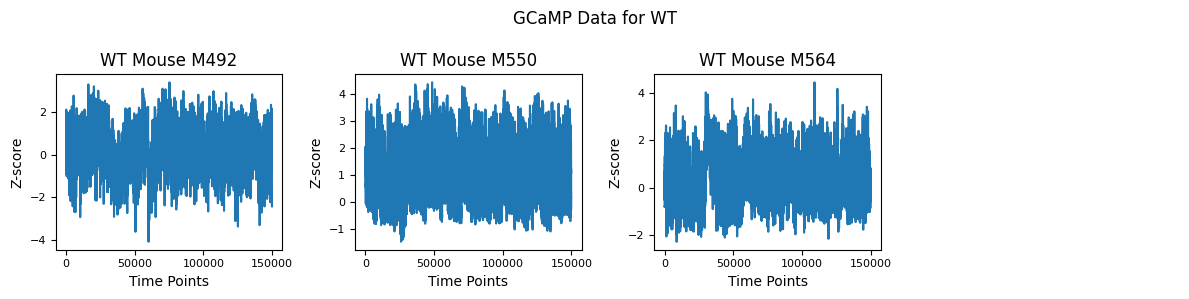

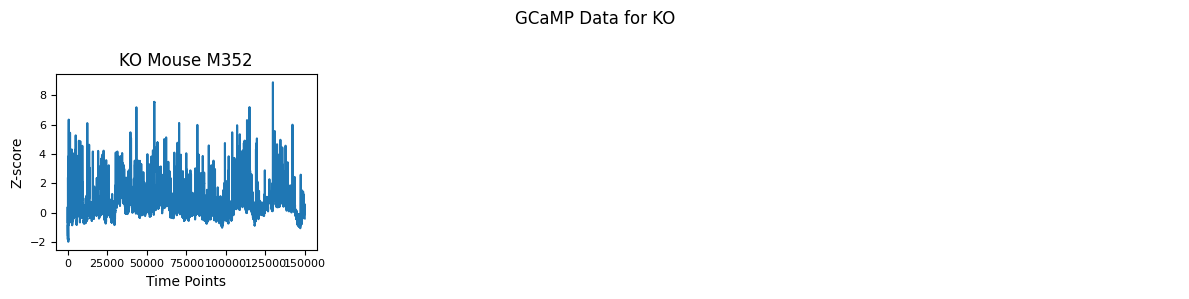

C:\Users\urimons.WISMAIN\AppData\Local\Temp\ipykernel_7596\2954248527.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  group_table = pd.concat([group_table, table], ignore_index=True)
C:\Users\urimons.WISMAIN\AppData\Local\Temp\ipykernel_7596\2954248527.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  group_table = pd.concat([group_table, table], ignore_index=True)


Combined results table for WT mice:
     mouse_id event peak_index  peak_time_s  event_window_start  \
0        M492     1        122         2.44           58.077623   
1        M564     1        353         7.06          240.540647   
2        M492     2        639        12.78          602.789407   
3        M550     1        759        15.18          750.694318   
4        M550     2        866        17.32          848.617227   
...       ...   ...        ...          ...                 ...   
1380     M492   380     149438      2988.76       149409.159433   
1381     M564   386     149464      2989.28       149431.097827   
1382     M550   617     149513      2990.26       149506.394045   
1383     M492   381     149686      2993.72       149656.239904   
1384     M550   618     149706      2994.12       149699.357744   

      event_window_end  peak_amp     width_ms  inst_freq  isi_s      AUC  
0           201.773772  2.114028  2023.922981        NaN    NaN  4039.32  
1        

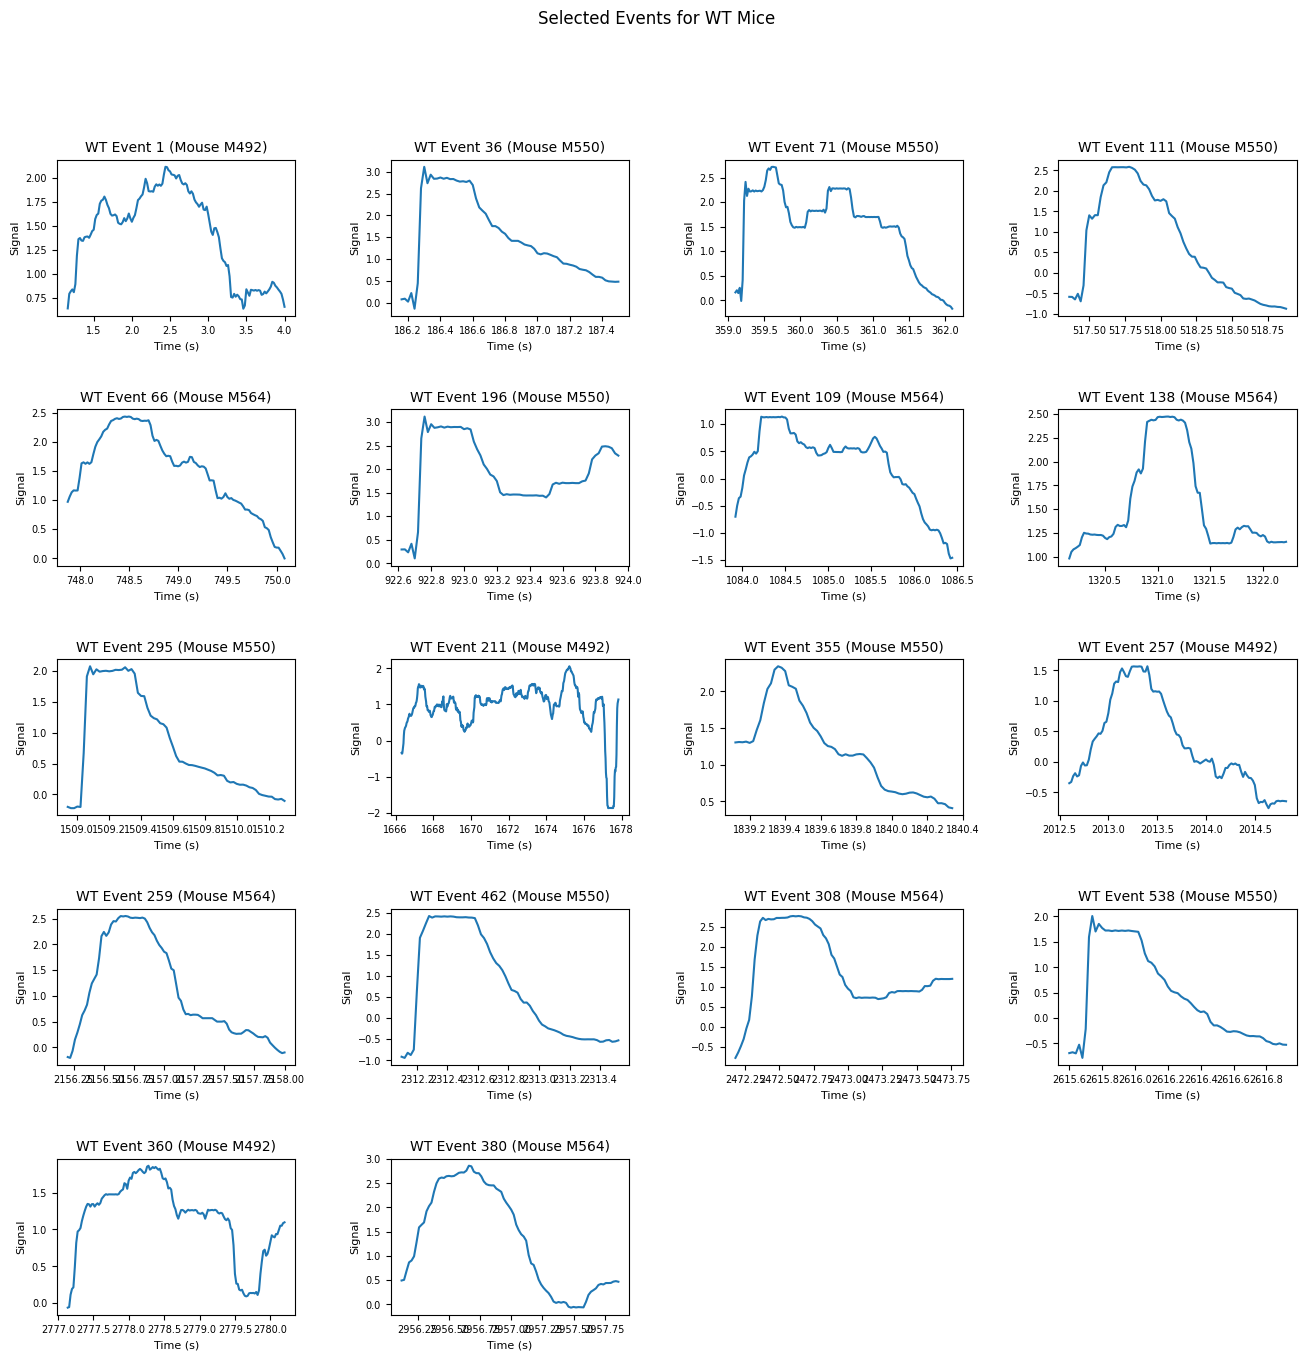

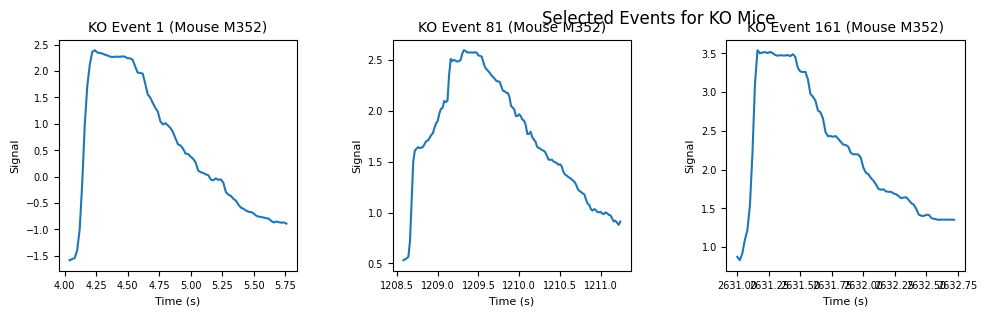


Peak statistics per bin for WT mice:
   mouse_id  bin_start  bin_end  peak_count  avg_amplitude  std_amplitude  \
0      M492          0    15000          45       1.698626       0.331781   
1      M492      15000    30000          52       2.251489       0.457179   
2      M492      30000    45000          19       1.493835       0.341645   
3      M492      45000    60000          35       1.779990       0.518363   
4      M492      60000    75000          34       2.126436       0.481872   
5      M492      75000    90000          40       1.990687       0.516978   
6      M492      90000   105000          42       1.797673       0.429901   
7      M492     105000   120000          39       1.792148       0.466518   
8      M492     120000   135000          43       1.624044       0.366524   
9      M492     135000   150000          32       1.916390       0.440512   
10     M550          0    15000          60       2.641149       0.635226   
11     M550      15000    30000       

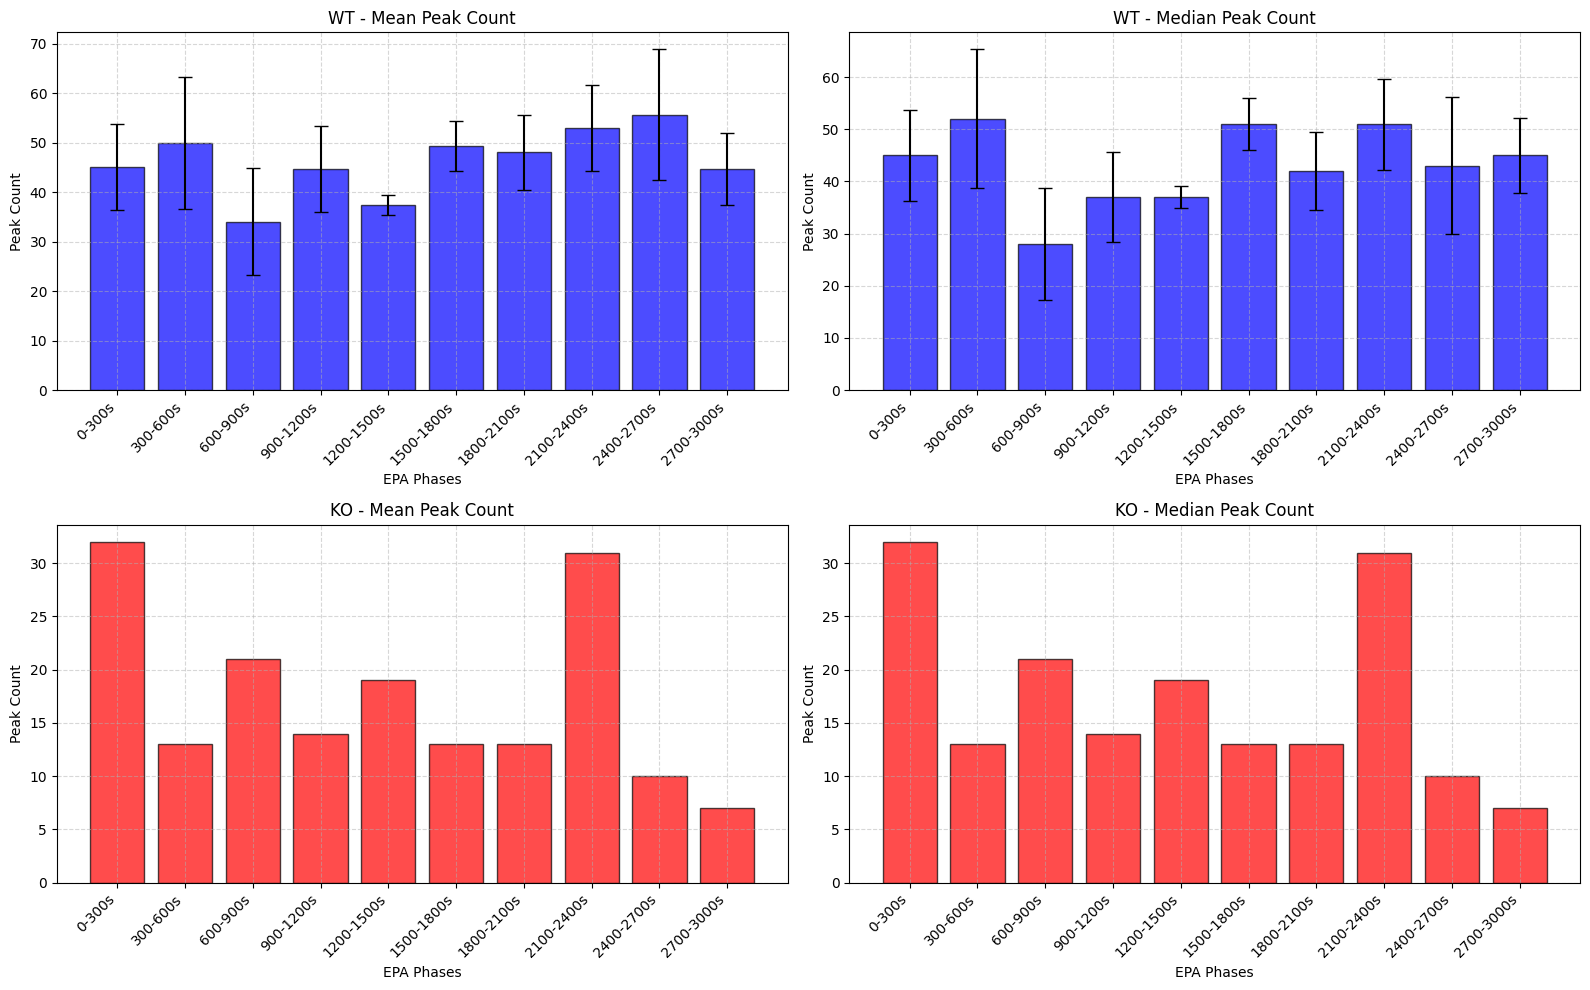

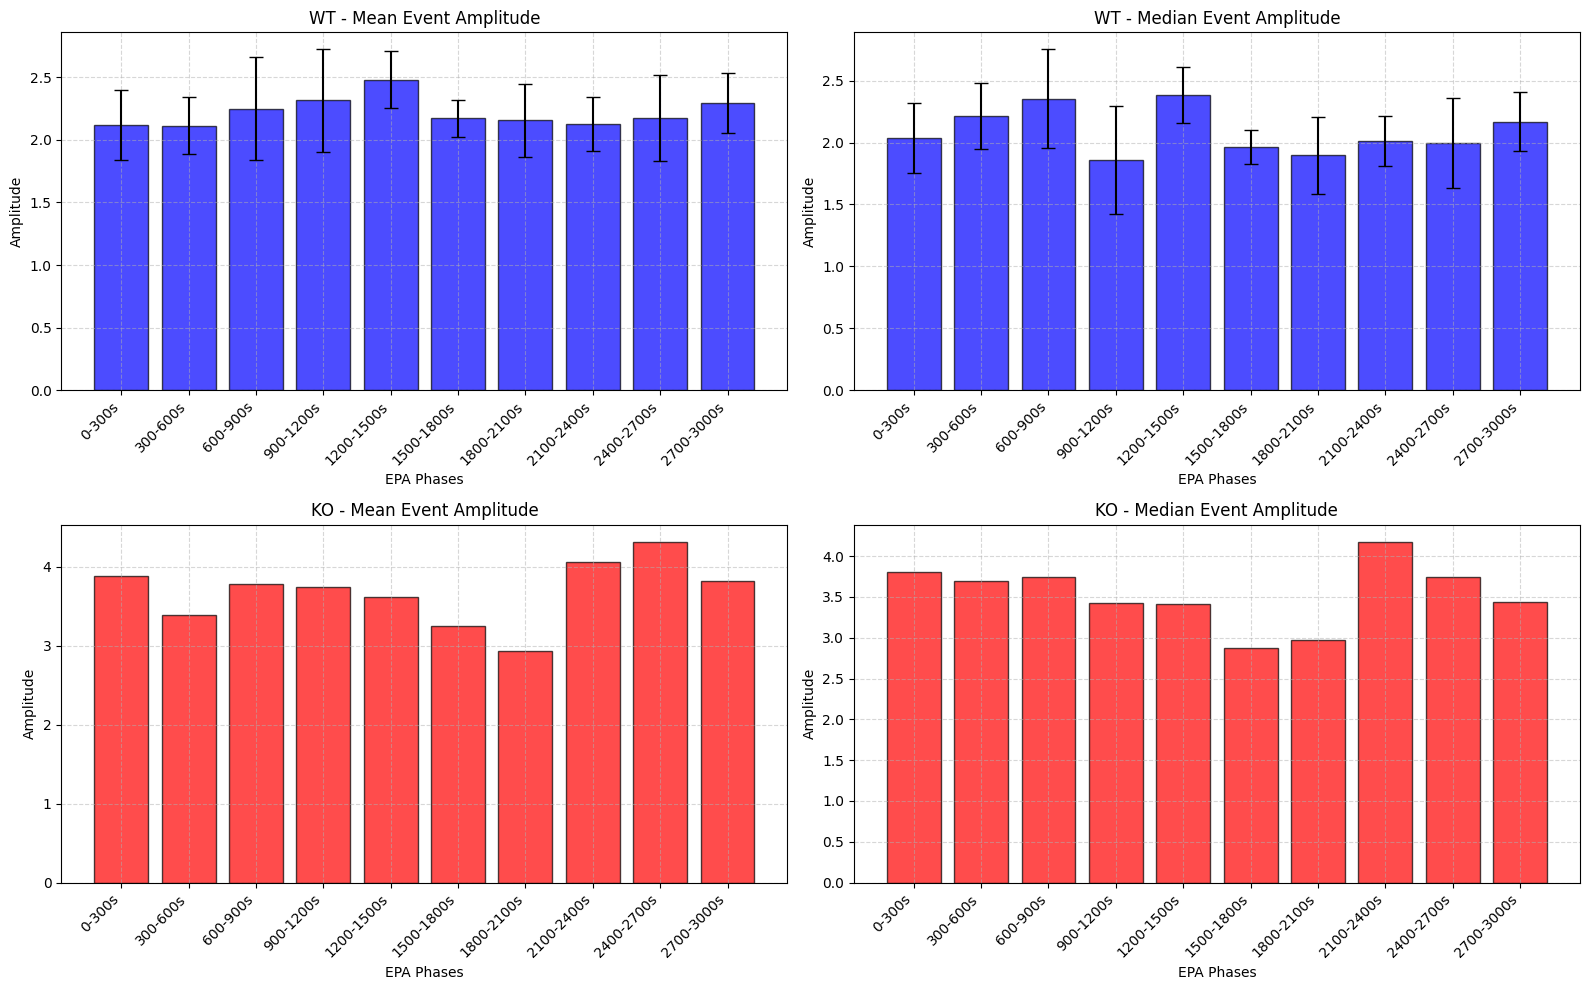

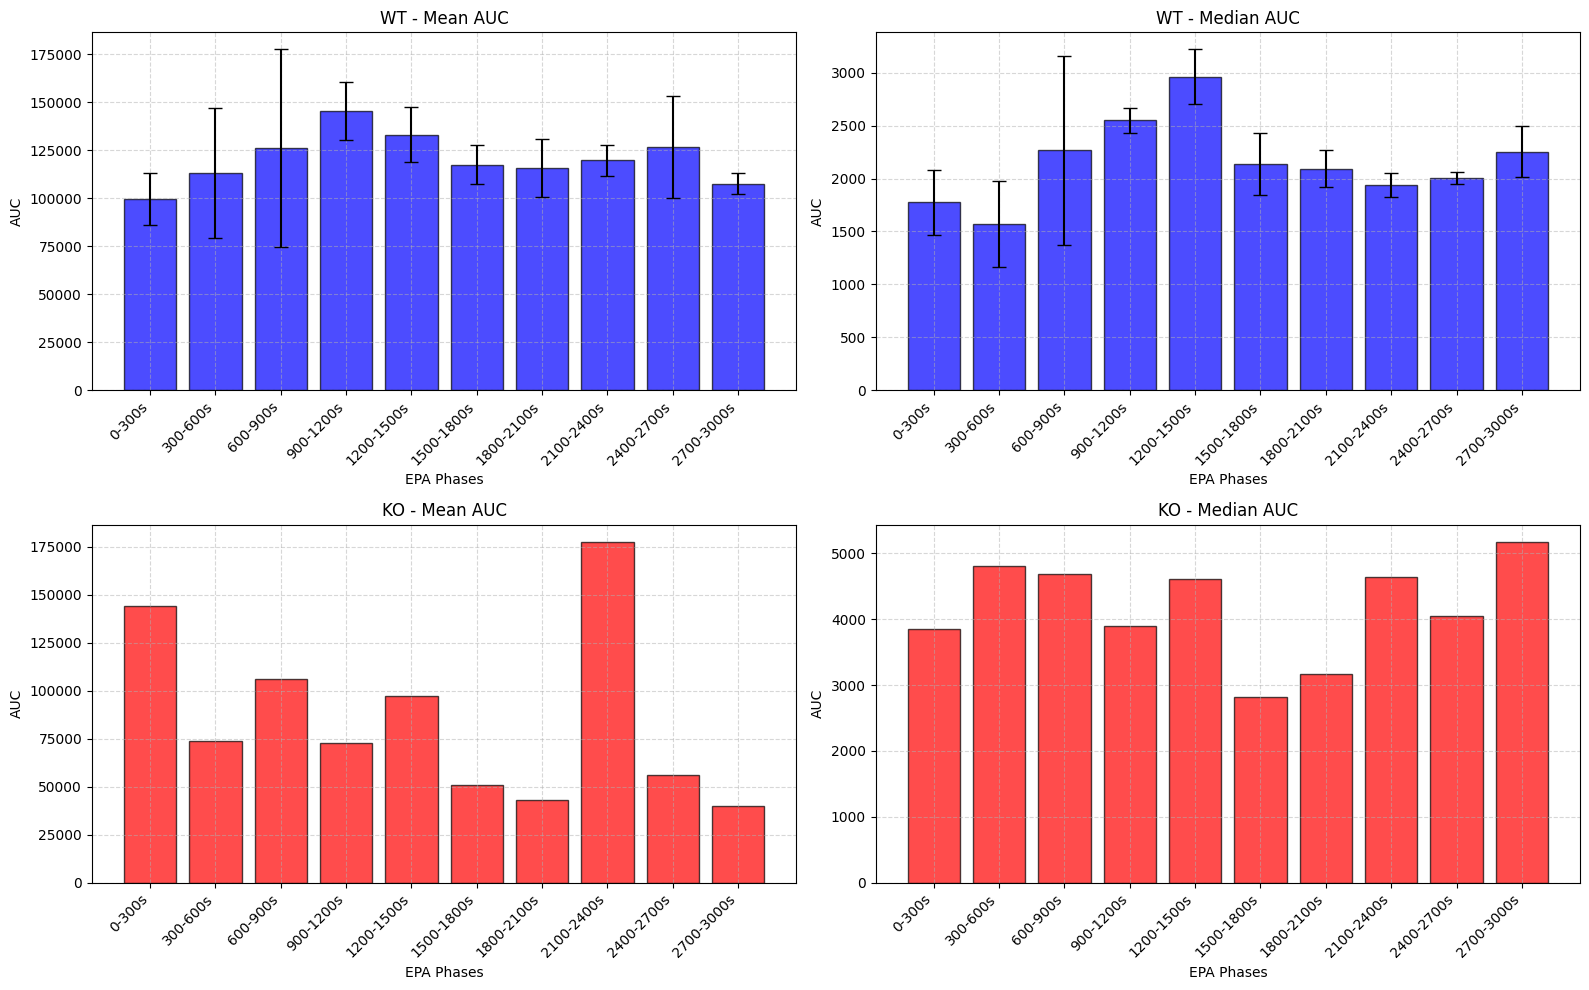

In [60]:
def main():
    experiments = load_experiments(DATA_FOLDER)
    group_WT, group_KO = separate_groups(experiments)

    filtered_WT = process_gcamp_data(group_WT)
    filtered_KO = process_gcamp_data(group_KO)

    print(f"Total WT mice with GCaMP data: {len(filtered_WT)}")
    print(f"Total KO mice with GCaMP data: {len(filtered_KO)}")

    # Per-mouse traces
    plot_gcamp_data(filtered_WT, "WT")
    plot_gcamp_data(filtered_KO, "KO")

    # Peaks tables (safe on empty)
    wt_table = process_group_peaks(filtered_WT, "WT")
    ko_table = process_group_peaks(filtered_KO, "KO")

    # Event plots (safe on empty)
    plot_selected_events(wt_table, filtered_WT, "WT", event_step=80)
    plot_selected_events(ko_table, filtered_KO, "KO", event_step=80)

    # Peak stats per bin + group summary (safe on empty)
    wt_peak_stats_df = compute_peak_stats_per_bin(filtered_WT, "WT")
    ko_peak_stats_df = compute_peak_stats_per_bin(filtered_KO, "KO")

    wt_overall_peak_stats = compute_group_peak_stats(wt_peak_stats_df, "WT")
    ko_overall_peak_stats = compute_group_peak_stats(ko_peak_stats_df, "KO")

    # AUC stats per bin + group summary (safe on empty)
    wt_auc_stats_df = compute_auc_per_bin(filtered_WT, "WT")
    ko_auc_stats_df = compute_auc_per_bin(filtered_KO, "KO")

    wt_overall_auc_stats = compute_group_auc_stats(wt_auc_stats_df, "WT")
    ko_overall_auc_stats = compute_group_auc_stats(ko_auc_stats_df, "KO")

    # Width stats (safe on empty)
    wt_width_stats_df = compute_width_stats_per_bin(wt_table, "WT")
    ko_width_stats_df = compute_width_stats_per_bin(ko_table, "KO")

    # Comparison plots only if BOTH groups have data
    if wt_overall_peak_stats is not None and not wt_overall_peak_stats.empty and \
       ko_overall_peak_stats is not None and not ko_overall_peak_stats.empty:
        plot_peak_count_stats(wt_overall_peak_stats, ko_overall_peak_stats)
        plot_amplitude_stats(wt_overall_peak_stats, ko_overall_peak_stats)
    else:
        print("Skipping WT vs KO peak/amplitude comparison plots (one group missing).")

    if wt_overall_auc_stats is not None and not wt_overall_auc_stats.empty and \
       ko_overall_auc_stats is not None and not ko_overall_auc_stats.empty:
        plot_auc_stats(wt_overall_auc_stats, ko_overall_auc_stats)
    else:
        print("Skipping WT vs KO AUC comparison plots (one group missing).")

    # Uncomment if you want saving (also safe)
    # save_group_stats(wt_overall_peak_stats, wt_overall_auc_stats, ko_overall_peak_stats, ko_overall_auc_stats)


if __name__ == '__main__':
    main()